In [58]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch
import torch.autograd
from torch.optim import AdamW, SGD, Adam
import torch.nn

import random
import stim
import stim_model
import cpn_model
import utils


# A 'Thing' is the thing we are stimulating. It is basically
# a single variable diffeq-goverened system that merely dampens
# over time, except a stimulation can excite it.
class Thing(object):
    def __init__(self, init=0.0, decay=0.7):
        assert isinstance(init, float)
        self.x = init
        self.decay = decay

    def observe(self):
        return self.x

    def step(self, input):
        assert isinstance(input, float)
        self.x += input
        self.x = self.decay * self.x
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Problem 1:
# We will recapitulate sine waves with various starting
# phases. 'steps' is the trial length
steps = 200
batch_size = 256
# y=target, x=phase
target = torch.zeros((batch_size, steps, 2))
for bidx in range(batch_size):
    offset = bidx / float(batch_size)
    for i in range(steps):
        t = torch.tensor(6 * (i / 100.0) + offset)
        target[bidx, i, 0] = torch.sin(t)
        target[bidx, i, 1] = t
        
target = target[torch.randperm(target.shape[0]), :, :]

In [60]:
# Problem 2:
# Alternate, more difficult problem that involves memory.
# Learning isn't working here yet.
# We will recapitulate sine waves with various starting
# frequencies. 'steps' is the trial length
steps = 100
show_steps = 10
hold_steps = 20
batch_size = 256
# y=target, x=(target freq, hold signal)
target = torch.zeros((batch_size, steps, 3))
for bidx in range(batch_size):
    freq = bidx * 15 / float(batch_size) + 2
    x = bidx / float(batch_size)
    for i in range(steps):     
        # This is a harder problem involving memory, which looks
        # a lot like the the Michaels problem
        # Dim 1: the target value
        if i < hold_steps:
            target[bidx, i, 0] = 0.0
        else:
            t = torch.tensor(freq * ((i - hold_steps)/ 100.0))
            target[bidx, i, 0] = torch.sin(t)
        
        # Dim 2: the target freq
        if i < show_steps:
            target[bidx, i, 1] = torch.tensor(x)
        else:
            target[bidx, i, 1] = 0.0
            
        # Dim 3: the hold signal
        if i < hold_steps:
            target[bidx, i, 2] = 1.0
        else:
            target[bidx, i, 2] = 0.0

In [63]:
# Train a BEN on a collection of CPNs, centered at the given CPN,
#  with mean 0 noise added to the weights.

      
def make_noised_cpn(cpn, var=0.1):
    cpn_out = cpn_model.CPNModel(cpn.in_dim, cpn.out_dim, num_neurons=cpn.num_neurons,
                                 activation_func=cpn.activation_func_t)
    cpn_out.load_state_dict(cpn.state_dict())
    
    with torch.no_grad():
        for p in cpn_out.parameters():
            noise = var * (torch.rand(p.shape) - 0.5)
            p.data = p.data + p.data * noise
            
    return cpn_out

def train_a_ben(cpn, ben=None, last_loss=1):
    global recent_ben
    
    # An observation of a 1 dimensional thing, 1 dimension of stimulation, 1 dimension 'x'
    if ben is None or last_loss > 0.05:
        ben = stim_model.StimModelLSTM(target.shape[-1] + 1, 1, num_neurons=20,
                                   activation_func=torch.nn.Tanh)
        recent_ben = ben
    vl = torch.ones(1)
    opt_ben = AdamW(ben.parameters(), lr=9e-3, weight_decay=0.02)

    checkpoint_eidx = 0
    for eidx in range(10000000):
        opt_ben.zero_grad()
        ben.reset()
        cpn.reset()
        loss = torch.nn.MSELoss()
        all_obs = torch.zeros(batch_size, steps, requires_grad=False)
        preds = torch.zeros(batch_size, steps)
        
        for p in opt_ben.param_groups:
            if eidx < 3:
                p['lr'] = 2e-2
            else:
                #p['lr'] = min(max(1e-4, 0.4192 * vl.item()), 3e-3)
                #p['lr'] = min(max(1e-3, 0.4192 * vl.item()), 3e-3)
                if vl.item() < 0.005:
                    p['lr'] = 5e-3
                else:
                    p['lr'] = 9e-3
                
    
        random_targets = target[torch.randperm(target.shape[0]), :, :]
        cpn_noise = cpn_model.CPNNoiseyLSTMCollection(cpn, noise_var=(0.1 * last_loss))
        # Just in case...
        for param in cpn_noise.parameters():
            param.requires_grad=False
            
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        for tidx in range(steps):
            obs = [t.observe() for t in things]
            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
          
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn_noise(cpn_in)
        
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            preds[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
        
        rl = loss(preds, all_obs)
        rl.backward()
        opt_ben.step()
        
        # Verify against the actual CPN
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        obs_val = torch.zeros(batch_size, steps)
        preds_val = torch.zeros(batch_size, steps)
        opt_ben.zero_grad()
        cpn.reset()
        ben.reset()
        for tidx in range(steps):
            obs = [t.observe() for t in things]
            new_obs = torch.tensor(obs).reshape(256,1)
            obs_val[:, tidx:tidx+1] = new_obs
          
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn(cpn_in)
        
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            preds_val[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            obs = []
            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
        
        vl = loss(preds_val, obs_val)
        print("ben", eidx, rl.item(), "first 80:",
              loss(preds[:80, :], all_obs[:80, :]).item(),
              "val:", vl.item())
                
        if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 1.5 or (eidx - checkpoint_eidx) > 5000:
            # Emergency eject button
            ben = stim_model.StimModelLSTM(ben.in_dim, ben.out_dim, num_neurons=ben.num_neurons,
                                       activation_func=ben.activation_func_t)
            recent_ben = ben
            opt_ben = AdamW(ben.parameters(), lr=1e-3, weight_decay=0.02)
            checkpoint_eidx = eidx
            
        if vl.item() < max(0.01 * last_loss, 0.0007) and eidx > 200:
            opt_ben.zero_grad()
            break
            
    return ben

In [ ]:
# @preston: this is the core learning algorithm, and seems to be
# able to converge if the problem is structured in a sane way.
#
# In essence: this training loop trains until the (B)EN reaches a
#  certain threshold of loss on the untrained CPN. This can take
#  awhile to converge. Once it does, the CPN will be trained. The
#  BEN is then retrained until it converges again. That way: we only
#  ever train the CPN on an 'accurate' BEN.
#
# Adding the "label" input, which is the second column in target, is
# necessary. Alternatively once could start every trial at the same
# phase - basically memorizing one exact sine wave.


#  1 dimension of stim param, output

#cpn = cpn_model.CPNModelLSTM(target.shape[-1], 1, num_neurons=20, activation_func=torch.nn.Tanh)
#cpn.load_state_dict(torch.load('latest_cpn'))
#opt_cpn = AdamW(cpn.parameters(), lr=1e-4)

loss = torch.nn.MSELoss()

rli = 0.02

cpn_losses = []
super_epoch_count = 0
ben = recent_ben
while True:       
    super_epoch_count += 1
    
    for param in cpn.parameters():
        param.requires_grad=False
    # @preston: retraining an existing ben doesn't work - it never converges.
    
    #    ben = train_a_ben(cpn, ben=ben, last_loss=rli)
    if super_epoch_count > 1:
        ben = train_a_ben(cpn, last_loss=rli)
    #bens.append(ben)
    for param in cpn.parameters():
        param.requires_grad=True
    for param in ben.parameters():
        param.requires_grad=False
        
    recent_losses = []
    for eidx in range(5000):
        opt_cpn.zero_grad()
        cpn.reset()
        ben.reset()
    
        thing = [Thing(init=x.item()) for x in target[:, 0, 0].detach().numpy()]
    
        pred = torch.zeros((256, steps))
        # This is actually very simple in our single variable context: it outputs
        # a stimulation value which decays to 0 over time.
        # The 'padding' is a cludgy, ugly thing that you can ignore; it's for
        #  the purpose of applying to the Michaels model. I may remove it later.
        s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
    
        all_obs = torch.zeros(256, steps)
        stims = []

        for tidx in range(steps):
            obs = [t.observe() for t in thing]
            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
          
            x = target[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn(cpn_in)
            new_stim.retain_grad()
        
            x = target[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            pred[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            stims.append(new_stim)
            n = s.get_next().detach().numpy()

            for bidx in range(batch_size):
                thing[bidx].step(n[bidx, 0].item())

            
        rl = loss(pred, target[:, :, 0])
        rli = rl.item()
        rl.backward()  

        real_loss = loss(all_obs, target[:, :, 0])
        print("cpn", eidx, rl.item(), loss(pred, all_obs).item(), real_loss.item())
        recent_losses.append(real_loss.item())
                                                          
        # Emergency bailout; we diverged; start over :(
        if recent_losses[-1] > 2.0:
            cpn = cpn_model.CPNModelLSTM(target.shape[-1], cpn.out_dim,
                                     num_neurons=cpn.num_neurons,
                                     activation_func=cpn.activation_func_t)
            opt_cpn = AdamW(cpn.parameters(), lr=1e-4)
            break
                    
        torch.save(cpn.state_dict(), "latest_cpn")
        torch.save(ben.state_dict(), "latest_ben")
            
        # Emergency bailout; time to retrain ben
        if len(recent_losses) > 12 and (recent_losses[-1] > recent_losses[0] * 1.2):
            ben = None
            break
        # Done
        elif rli < 0.003:
            break
        elif len(recent_losses) > 12:
            prev = None
            num_regressed = 0
            for l in recent_losses[-12:]:
                if prev is not None and l > prev:
                    num_regressed += 1
                        
                prev = l
            
            if num_regressed > 3 and loss(pred, all_obs).item() > rli or num_regressed > 8:
                if eidx < 20:
                    ben = None
                break
              
        cpn_losses.append(rli)
        opt_cpn.step()
        
    if rli < 0.003:
        break

plt.plot(pred[-1,:].detach().numpy())
plt.plot(all_obs[-1,:].detach().numpy())
plt.plot(target[-1, :, 0].detach().numpy())
plt.show()

cpn 0 0.1052689179778099 0.0002415957860648632 0.10626231133937836
cpn 1 0.10775981843471527 0.00023997679818421602 0.10875197499990463
cpn 2 0.10725633800029755 0.00023841607617214322 0.10825426131486893
cpn 3 0.10493435710668564 0.00023725908249616623 0.10595600306987762
cpn 4 0.10218320041894913 0.00023662939202040434 0.10324852913618088
cpn 5 0.09786476939916611 0.00023631099611520767 0.09899517893791199
cpn 6 0.09264514595270157 0.00023554735525976866 0.09385719150304794
cpn 7 0.08949390053749084 0.0002327155089005828 0.09078662842512131
cpn 8 0.09170732647180557 0.0002253816492157057 0.09305538237094879
cpn 9 0.10859408974647522 0.00021219608606770635 0.10996074974536896
cpn 10 0.1329064965248108 0.0002052952186204493 0.13430248200893402
cpn 11 0.13732656836509705 0.00021043048764113337 0.13873840868473053
cpn 12 0.15892571210861206 0.00020279534510336816 0.16028860211372375
ben 0 0.3478405773639679 first 80: 0.33718135952949524 val: 0.2558951675891876
ben 1 0.24628497660160065 f

ben 85 0.0007691371720284224 first 80: 0.0007570994785055518 val: 0.0007198128150776029
ben 86 0.0007501954096369445 first 80: 0.0007394250715151429 val: 0.000710609252564609
ben 87 0.0007526830304414034 first 80: 0.0007657068781554699 val: 0.0007014477741904557
ben 88 0.0007532882736995816 first 80: 0.0007845228537917137 val: 0.0006908054929226637
ben 89 0.0007113831234164536 first 80: 0.0006834594532847404 val: 0.0006797994137741625
ben 90 0.0007268881890922785 first 80: 0.0007617995725013316 val: 0.0006688436260446906
ben 91 0.000718260242138058 first 80: 0.000722458295058459 val: 0.0006592209101654589
ben 92 0.000703316880390048 first 80: 0.0007259375415742397 val: 0.0006515651475638151
ben 93 0.0006854725652374327 first 80: 0.0007185094873420894 val: 0.0006446518236771226
ben 94 0.0006966268992982805 first 80: 0.0006972832488827407 val: 0.0006376014789566398
ben 95 0.0006888193893246353 first 80: 0.0006906604394316673 val: 0.0006301359971985221
ben 96 0.0006515529239550233 first 8

ben 177 0.0003364850126672536 first 80: 0.00033207464730367064 val: 0.0002902305277530104
ben 178 0.00032919467776082456 first 80: 0.0003279120719525963 val: 0.00028737637330777943
ben 179 0.0003341106930747628 first 80: 0.0003392854705452919 val: 0.0002845445997081697
ben 180 0.0003165154776070267 first 80: 0.00031750131165608764 val: 0.000281842309050262
ben 181 0.00031255302019417286 first 80: 0.0003236534248571843 val: 0.00027915521059185266
ben 182 0.00031377311097458005 first 80: 0.00030702113872393966 val: 0.0002764835662674159
ben 183 0.00031061176559887826 first 80: 0.0003123301430605352 val: 0.0002738314215093851
ben 184 0.00030952043016441166 first 80: 0.0003237775817979127 val: 0.00027122354367747903
ben 185 0.0003038712893612683 first 80: 0.0002822027017828077 val: 0.00026863525272347033
ben 186 0.00030800330569036305 first 80: 0.0003065698256250471 val: 0.0002660424797795713
ben 187 0.00030500287539325655 first 80: 0.00030161457834765315 val: 0.00026348355459049344
ben 18

ben 40 0.0027013218495994806 first 80: 0.002723630052059889 val: 0.002558609005063772
ben 41 0.002695762785151601 first 80: 0.002668314380571246 val: 0.002550906501710415
ben 42 0.00269297300837934 first 80: 0.0026475172489881516 val: 0.002536518033593893
ben 43 0.0026316188741475344 first 80: 0.002703409641981125 val: 0.0025064635556191206
ben 44 0.0026127323508262634 first 80: 0.0026333590503782034 val: 0.002455700421705842
ben 45 0.002550787292420864 first 80: 0.0024566950742155313 val: 0.0023844316601753235
ben 46 0.002537881024181843 first 80: 0.002496575005352497 val: 0.0022962919902056456
ben 47 0.0023940636310726404 first 80: 0.0024559986777603626 val: 0.002204363700002432
ben 48 0.0022971108555793762 first 80: 0.00229200953617692 val: 0.0021189134567976
ben 49 0.002165037440136075 first 80: 0.002191235776990652 val: 0.002049884293228388
ben 50 0.0021080435253679752 first 80: 0.0021395462099462748 val: 0.0020006822887808084
ben 51 0.0020186523906886578 first 80: 0.0020325321238

ben 134 0.0005911228363402188 first 80: 0.0005846581188961864 val: 0.0005736578023061156
ben 135 0.0005870779859833419 first 80: 0.0006312204641290009 val: 0.0005684656789526343
ben 136 0.0005926444428041577 first 80: 0.0006026275805197656 val: 0.0005633157561533153
ben 137 0.0005887252627871931 first 80: 0.0005974542582407594 val: 0.0005580461584031582
ben 138 0.0005836107302457094 first 80: 0.0005616927519440651 val: 0.0005526550230570138
ben 139 0.0005740130436606705 first 80: 0.0005724317743442953 val: 0.0005473868804983795
ben 140 0.0005654275300912559 first 80: 0.0005808957503177226 val: 0.0005423733382485807
ben 141 0.0005701033514924347 first 80: 0.0005546016036532819 val: 0.0005376174813136458
ben 142 0.0005709377001039684 first 80: 0.0005856015486642718 val: 0.0005330568528734148
ben 143 0.0005506402812898159 first 80: 0.0005435447092168033 val: 0.0005285104853101075
ben 144 0.0005339051131159067 first 80: 0.0005267279339022934 val: 0.0005239560268819332
ben 145 0.00054243690

cpn 31 0.18187366425991058 0.00030355973285622895 0.18231196701526642
cpn 32 0.17891402542591095 0.00029538938542827964 0.17920193076133728
cpn 33 0.18059514462947845 0.00029748151428066194 0.18089407682418823
cpn 34 0.1845507174730301 0.0003031152591574937 0.18491590023040771
cpn 35 0.18390750885009766 0.0003001768491230905 0.1842097043991089
cpn 36 0.1809651255607605 0.0002929557813331485 0.18114684522151947
cpn 37 0.1819218248128891 0.0002937355893664062 0.18210840225219727
cpn 38 0.1852010190486908 0.00029878440545871854 0.18545953929424286
cpn 39 0.18464933335781097 0.00029728043591603637 0.18488837778568268
cpn 40 0.18180321156978607 0.0002916638914030045 0.18196888267993927
cpn 41 0.18210159242153168 0.00029189957422204316 0.18227924406528473
cpn 42 0.18453654646873474 0.0002958824625238776 0.1847793161869049
cpn 43 0.18414625525474548 0.00029481606907211244 0.18438473343849182
cpn 44 0.18161387741565704 0.0002899075916502625 0.18179793655872345
cpn 45 0.18135131895542145 0.0002

cpn 150 0.16552434861660004 0.000271480530500412 0.16562098264694214
cpn 151 0.16548508405685425 0.00027147491346113384 0.1655799299478531
cpn 152 0.16544251143932343 0.0002714588481467217 0.1655355840921402
cpn 153 0.16539683938026428 0.0002714331494644284 0.1654881238937378
cpn 154 0.1653541624546051 0.00027141705504618585 0.1654437631368637
cpn 155 0.16531474888324738 0.0002714114962145686 0.16540274024009705
cpn 156 0.16527298092842102 0.0002713988069444895 0.16535936295986176
cpn 157 0.16522841155529022 0.0002713776775635779 0.16531319916248322
cpn 158 0.16518619656562805 0.0002713635622058064 0.16526944935321808
cpn 159 0.16514705121517181 0.0002713586436584592 0.16522884368896484
cpn 160 0.16510629653930664 0.00027134790434502065 0.16518665850162506
cpn 161 0.1650635004043579 0.0002713296271394938 0.16514240205287933
cpn 162 0.16502276062965393 0.0002713167341426015 0.16510024666786194
cpn 163 0.16498465836048126 0.00027131091337651014 0.16506080329418182
cpn 164 0.1649456769227

cpn 268 0.1621461808681488 0.0002707250532694161 0.16213613748550415
cpn 269 0.16212932765483856 0.00027071984368376434 0.16211873292922974
cpn 270 0.16211280226707458 0.0002707151579670608 0.16210167109966278
cpn 271 0.1620962917804718 0.0002707100356929004 0.16208462417125702
cpn 272 0.16207990050315857 0.00027070456417277455 0.16206766664981842
cpn 273 0.16206373274326324 0.00027069906354881823 0.16205093264579773
cpn 274 0.16204778850078583 0.00027069405768997967 0.16203443706035614
cpn 275 0.16203191876411438 0.00027068855706602335 0.1620180755853653
cpn 276 0.1620161384344101 0.0002706827945075929 0.16200175881385803
cpn 277 0.16200053691864014 0.0002706768864300102 0.1619856059551239
cpn 278 0.16198521852493286 0.0002706715895328671 0.16196979582309723
cpn 279 0.16196992993354797 0.0002706656523514539 0.16195397078990936
cpn 280 0.16195468604564667 0.0002706592786125839 0.16193825006484985
cpn 281 0.161939799785614 0.0002706533414311707 0.1619228571653366
cpn 282 0.1619250178337

cpn 386 0.16109880805015564 0.0002689866814762354 0.16106054186820984
cpn 387 0.1610979437828064 0.0002689550747163594 0.16105981171131134
cpn 388 0.16109710931777954 0.00026892300229519606 0.1610591560602188
cpn 389 0.1610967218875885 0.0002688910171855241 0.1610589474439621
cpn 390 0.161096453666687 0.00026885882834903896 0.16105884313583374
cpn 391 0.16109618544578552 0.00026882532984018326 0.16105875372886658
cpn 392 0.16109614074230194 0.00026879156939685345 0.16105888783931732
cpn 393 0.16109634935855865 0.0002687582455109805 0.16105930507183075
cpn 394 0.16109663248062134 0.0002687237865757197 0.16105979681015015
cpn 395 0.1610969603061676 0.0002686886000446975 0.16106033325195312
cpn 396 0.16109760105609894 0.0002686535590328276 0.16106122732162476
cpn 397 0.1610983908176422 0.0002686179941520095 0.16106225550174713
cpn 398 0.16109929978847504 0.0002685818471945822 0.16106341779232025
cpn 399 0.16110029816627502 0.0002685451181605458 0.16106468439102173
cpn 400 0.16110149025917

ben 83 0.0004358264559414238 first 80: 0.00042895242222584784 val: 0.00042609148658812046
ben 84 0.00041452099685557187 first 80: 0.0003984200884588063 val: 0.0004218843823764473
ben 85 0.0004315759870223701 first 80: 0.0004176246002316475 val: 0.00041768013034015894
ben 86 0.0004180452961008996 first 80: 0.00038534955820068717 val: 0.00041311781387776136
ben 87 0.000435991125414148 first 80: 0.0004071936709806323 val: 0.00040816780528984964
ben 88 0.00041998017695732415 first 80: 0.0003973226121161133 val: 0.00040315373917110264
ben 89 0.0004339601146057248 first 80: 0.0004484943056013435 val: 0.0003985248040407896
ben 90 0.0004412267589941621 first 80: 0.0004563353431876749 val: 0.00039442055276595056
ben 91 0.0003955835127271712 first 80: 0.00038532508187927306 val: 0.00039006982115097344
ben 92 0.000425025966251269 first 80: 0.00041947554564103484 val: 0.00038542895345017314
ben 93 0.00039703104994259775 first 80: 0.0004146463761571795 val: 0.000380305660655722
ben 94 0.00039571989

ben 174 0.00013946995022706687 first 80: 0.0001375913998344913 val: 0.0001338905858574435
ben 175 0.00013875745935365558 first 80: 0.00013529625721275806 val: 0.00013215755461715162
ben 176 0.00013705965830013156 first 80: 0.00014123877917882055 val: 0.0001300092408200726
ben 177 0.00013985656551085413 first 80: 0.0001388369273627177 val: 0.00012813886860385537
ben 178 0.00013201884576119483 first 80: 0.0001364764029858634 val: 0.00012654339661821723
ben 179 0.00012977950973436236 first 80: 0.00012134247663198039 val: 0.00012476403207983822
ben 180 0.00012861953291576356 first 80: 0.00013019057223573327 val: 0.00012289616279304028
ben 181 0.00012601219350472093 first 80: 0.00013385603961069137 val: 0.00012132055417168885
ben 182 0.0001264731981791556 first 80: 0.00012980110477656126 val: 0.00011987946345470846
ben 183 0.0001283323363168165 first 80: 0.0001310841180384159 val: 0.00011823298700619489
ben 184 0.00011659887968562543 first 80: 0.00012065422924933955 val: 0.00011648896906990

ben 56 0.0009486135095357895 first 80: 0.0009443183080293238 val: 0.0009677271009422839
ben 57 0.0009258246282115579 first 80: 0.0009512564283795655 val: 0.0009297808865085244
ben 58 0.0008867895812727511 first 80: 0.0008443543338216841 val: 0.0008988763438537717
ben 59 0.000880248611792922 first 80: 0.0008794543100520968 val: 0.0008775749593041837
ben 60 0.0008496805094182491 first 80: 0.0008937503444030881 val: 0.0008631156524643302
ben 61 0.0008158478885889053 first 80: 0.0008216780261136591 val: 0.0008504666620865464
ben 62 0.0008125689346343279 first 80: 0.0008209753432311118 val: 0.0008345249225385487
ben 63 0.0007955601904541254 first 80: 0.0007511074072681367 val: 0.0008153374656103551
ben 64 0.000790949328802526 first 80: 0.0008291071862913668 val: 0.0007950578583404422
ben 65 0.0007666599121876061 first 80: 0.0007775150006636977 val: 0.0007762707537040114
ben 66 0.0007701250142417848 first 80: 0.000724086828995496 val: 0.000757739704567939
ben 67 0.000710217806044966 first 80

ben 148 0.00022725116286892444 first 80: 0.00023217393027152866 val: 0.0002115390816470608
ben 149 0.00022932096908334643 first 80: 0.00022815176635049284 val: 0.0002097076940117404
ben 150 0.00021821679547429085 first 80: 0.0002255370345665142 val: 0.0002078240504488349
ben 151 0.0002151678199879825 first 80: 0.00023451331071555614 val: 0.00020607815531548113
ben 152 0.00022111913131084293 first 80: 0.00019546941621229053 val: 0.0002044568391283974
ben 153 0.00019761387375183403 first 80: 0.00019436463480815291 val: 0.00020264048362150788
ben 154 0.00021161414042580873 first 80: 0.00021859598928131163 val: 0.0002004163688980043
ben 155 0.00021035934332758188 first 80: 0.00020234650583006442 val: 0.00019819916633423418
ben 156 0.0002206401841249317 first 80: 0.0002272824349347502 val: 0.0001964341354323551
ben 157 0.00020285355276428163 first 80: 0.0002138644631486386 val: 0.00019486912060528994
ben 158 0.00020184075401630253 first 80: 0.00021572331024799496 val: 0.00019318722479511052

ben 15 0.0053979395888745785 first 80: 0.005413427483290434 val: 0.00468595651909709
ben 16 0.004834409337490797 first 80: 0.005059800576418638 val: 0.0047141327522695065
ben 17 0.004933016374707222 first 80: 0.0050402297638356686 val: 0.004701223690062761
ben 18 0.004739674739539623 first 80: 0.0047010076232254505 val: 0.004639842547476292
ben 19 0.004695539362728596 first 80: 0.00462886318564415 val: 0.004556308500468731
ben 20 0.004636026453226805 first 80: 0.004633347969502211 val: 0.004473828244954348
ben 21 0.004481091164052486 first 80: 0.004416240379214287 val: 0.004375440999865532
ben 22 0.004431192297488451 first 80: 0.004482893738895655 val: 0.004207430873066187
ben 23 0.0041013918817043304 first 80: 0.004064885899424553 val: 0.003940132446587086
ben 24 0.003947071265429258 first 80: 0.0039091031067073345 val: 0.0035843478981405497
ben 25 0.0035570336040109396 first 80: 0.0036189910024404526 val: 0.0031886505894362926
ben 26 0.0031822689343243837 first 80: 0.0031646471470594

ben 109 0.00032375045702792704 first 80: 0.00032676832051947713 val: 0.0002904039283748716
ben 110 0.00030076957773417234 first 80: 0.00031019351445138454 val: 0.0002851253666449338
ben 111 0.0002995220711454749 first 80: 0.0002969436754938215 val: 0.00027986831264570355
ben 112 0.000294241908704862 first 80: 0.0003089692327193916 val: 0.0002745952515397221
ben 113 0.00028963389922864735 first 80: 0.0002967860200442374 val: 0.0002695547591429204
ben 114 0.0002735417801886797 first 80: 0.00028485138318501413 val: 0.00026475818594917655
ben 115 0.00028698579990305007 first 80: 0.000292849144898355 val: 0.00025977869518101215
ben 116 0.00027497802511788905 first 80: 0.0002783900417853147 val: 0.00025476617156527936
ben 117 0.000276424631010741 first 80: 0.00029378753970377147 val: 0.00024981258320622146
ben 118 0.00027365810819901526 first 80: 0.0002625226625241339 val: 0.00024463675799779594
ben 119 0.000264696660451591 first 80: 0.00023725694336462766 val: 0.0002398709621047601
ben 120 

ben 200 8.97394202183932e-05 first 80: 8.55706020956859e-05 val: 7.924310921225697e-05
ben 201 8.867604628903791e-05 first 80: 8.583844464737922e-05 val: 7.832450501155108e-05
cpn 0 0.16127701103687286 7.832450501155108e-05 0.16146034002304077
cpn 1 0.16130295395851135 7.833184645278379e-05 0.16148485243320465
cpn 2 0.16133293509483337 7.834604184608907e-05 0.16151361167430878
cpn 3 0.16137105226516724 7.83780196798034e-05 0.16155071556568146
cpn 4 0.16141542792320251 7.842528430046514e-05 0.16159427165985107
cpn 5 0.16145889461040497 7.847381493775174e-05 0.16163723170757294
cpn 6 0.16150371730327606 7.852711132727563e-05 0.16168169677257538
cpn 7 0.16155201196670532 7.858862227294594e-05 0.16172955930233002
cpn 8 0.16159750521183014 7.864625513320789e-05 0.1617746353149414
cpn 9 0.16163860261440277 7.869852561270818e-05 0.16181530058383942
cpn 10 0.16167756915092468 7.87528624641709e-05 0.16185371577739716
cpn 11 0.16170978546142578 7.880373595980927e-05 0.16188538074493408
cpn 12 0.

ben 83 0.0005744558293372393 first 80: 0.000536989071406424 val: 0.0005552576621994376
ben 84 0.000572765595279634 first 80: 0.0005435264320112765 val: 0.0005463656270876527
ben 85 0.0005641335155814886 first 80: 0.0005576986004598439 val: 0.0005381745868362486
ben 86 0.0005563594168052077 first 80: 0.0005854744231328368 val: 0.0005305788945406675
ben 87 0.000568121497053653 first 80: 0.0005775428144261241 val: 0.0005233893170952797
ben 88 0.0005439233500510454 first 80: 0.0005653725820593536 val: 0.0005161981098353863
ben 89 0.0005390529986470938 first 80: 0.000565054826438427 val: 0.0005089618498459458
ben 90 0.0004944631946273148 first 80: 0.00046485423808917403 val: 0.0005014771013520658
ben 91 0.0005003064288757741 first 80: 0.0004920132923871279 val: 0.0004940188955515623
ben 92 0.0004942044033668935 first 80: 0.00052403419977054 val: 0.0004868698015343398
ben 93 0.0004951096489094198 first 80: 0.0004945163382217288 val: 0.0004802136973012239
ben 94 0.0005014447961002588 first 80

ben 175 0.0002599705767352134 first 80: 0.0002664922794792801 val: 0.00024580792523920536
ben 176 0.0002549950440879911 first 80: 0.0002652980911079794 val: 0.00024413397477474064
ben 177 0.0002528316108509898 first 80: 0.0002476121298968792 val: 0.000242414214881137
ben 178 0.0002593949902802706 first 80: 0.00025253117200918496 val: 0.00024072587257251143
ben 179 0.000257351144682616 first 80: 0.00026591657660901546 val: 0.0002390439622104168
ben 180 0.0002556480176281184 first 80: 0.00024444746668450534 val: 0.00023740263713989407
ben 181 0.00024057943664956838 first 80: 0.00024822159321047366 val: 0.00023556806263513863
ben 182 0.00024529389338567853 first 80: 0.00023174281523097306 val: 0.00023373407020699233
ben 183 0.00024509651120752096 first 80: 0.00024476772523485124 val: 0.00023197403061203659
ben 184 0.0002494574582669884 first 80: 0.0002479123941157013 val: 0.00023027873248793185
ben 185 0.00024449784541502595 first 80: 0.0002450734027661383 val: 0.00022859431919641793
ben 

cpn 84 0.16104349493980408 0.00021313245815690607 0.16134153306484222
cpn 85 0.16102749109268188 0.00021333512268029153 0.16132670640945435
cpn 86 0.16101330518722534 0.00021355380886234343 0.16131360828876495
cpn 87 0.16099897027015686 0.00021377527446020395 0.16130036115646362
cpn 88 0.1609824150800705 0.00021398492390289903 0.16128499805927277
cpn 89 0.16096678376197815 0.00021420065604615957 0.16127048432826996
cpn 90 0.1609526425600052 0.0002144259779015556 0.16125741600990295
cpn 91 0.16093719005584717 0.00021464325254783034 0.16124309599399567
cpn 92 0.16092123091220856 0.00021485819888766855 0.16122829914093018
cpn 93 0.1609066128730774 0.00021508341887965798 0.16121475398540497
cpn 94 0.1608915776014328 0.0002153086825273931 0.16120079159736633
cpn 95 0.16087497770786285 0.0002155274705728516 0.1611853837966919
cpn 96 0.16085898876190186 0.00021575302525889128 0.16117054224014282
cpn 97 0.1608436405658722 0.00021598409512080252 0.16115626692771912
cpn 98 0.16082704067230225 0.

cpn 202 0.15931279957294464 0.0002423730620648712 0.15972694754600525
cpn 203 0.15930010378360748 0.0002426241699140519 0.15971504151821136
cpn 204 0.15928763151168823 0.00024287583073601127 0.15970337390899658
cpn 205 0.15927523374557495 0.00024312717141583562 0.15969176590442657
cpn 206 0.15926262736320496 0.00024337686772923917 0.15967997908592224
cpn 207 0.15925012528896332 0.00024362659314647317 0.15966826677322388
cpn 208 0.15923786163330078 0.00024387676967307925 0.15965679287910461
cpn 209 0.15922540426254272 0.00024412537459284067 0.15964514017105103
cpn 210 0.15921300649642944 0.0002443733683321625 0.15963351726531982
cpn 211 0.1592007726430893 0.00024462162400595844 0.15962207317352295
cpn 212 0.15918856859207153 0.0002448692684993148 0.15961065888404846
cpn 213 0.15917623043060303 0.00024511563242413104 0.15959908068180084
cpn 214 0.15916410088539124 0.00024536234559491277 0.15958774089813232
cpn 215 0.15915197134017944 0.0002456083020661026 0.1595763862133026
cpn 216 0.159

cpn 320 0.15809936821460724 0.00026764284120872617 0.15859366953372955
cpn 321 0.15809203684329987 0.00026781309861689806 0.15858688950538635
cpn 322 0.1580849289894104 0.00026798283215612173 0.15858031809329987
cpn 323 0.15807786583900452 0.0002681518963072449 0.15857379138469696
cpn 324 0.15807083249092102 0.00026832008734345436 0.15856730937957764
cpn 325 0.15806381404399872 0.00026848717243410647 0.1585608422756195
cpn 326 0.15805692970752716 0.00026865367544814944 0.15855447947978973
cpn 327 0.15805016458034515 0.000268819771008566 0.1585482507944107
cpn 328 0.15804342925548553 0.0002689849934540689 0.15854205191135406
cpn 329 0.15803669393062592 0.0002691489353310317 0.15853585302829742
cpn 330 0.15803007781505585 0.0002693122951313853 0.15852974355220795
cpn 331 0.15802353620529175 0.0002694751019589603 0.15852375328540802
cpn 332 0.1580170840024948 0.00026963723939843476 0.15851780772209167
cpn 333 0.15801063179969788 0.00026979806716553867 0.15851186215877533
cpn 334 0.1580042

cpn 438 0.1572618931531906 0.0002812678285408765 0.1577642560005188
cpn 439 0.1572393774986267 0.00028130222926847637 0.15774007141590118
cpn 440 0.15721580386161804 0.0002813336031977087 0.15771472454071045
cpn 441 0.15719130635261536 0.00028136250330135226 0.15768833458423615
cpn 442 0.15716591477394104 0.0002813888422679156 0.15766094624996185
cpn 443 0.15713950991630554 0.0002814124745782465 0.15763244032859802
cpn 444 0.1571120023727417 0.0002814327890519053 0.1576027274131775
cpn 445 0.1570834517478943 0.0002814495819620788 0.15757180750370026
cpn 446 0.1570538431406021 0.00028146334807388484 0.1575397253036499
cpn 447 0.15702320635318756 0.00028147391276434064 0.15750642120838165
cpn 448 0.1569913923740387 0.00028148063574917614 0.15747186541557312
cpn 449 0.1569584608078003 0.00028148319688625634 0.15743601322174072
cpn 450 0.15692439675331116 0.0002814815961755812 0.15739884972572327
cpn 451 0.15688925981521606 0.00028147612465545535 0.1573604792356491
cpn 452 0.15685296058654

cpn 556 0.1170593723654747 0.00026884544058702886 0.1172608882188797
cpn 557 0.11678241938352585 0.0002692484122235328 0.11699598282575607
cpn 558 0.11651256680488586 0.0002696511219255626 0.11673745512962341
cpn 559 0.11624547094106674 0.00027008121833205223 0.11648067831993103
cpn 560 0.11598644405603409 0.00027052476070821285 0.11623214930295944
cpn 561 0.11570659279823303 0.00027109344955533743 0.1159614622592926
cpn 562 0.11546451598405838 0.0002715660084504634 0.11573150753974915
cpn 563 0.11513570696115494 0.000272462610155344 0.11540663987398148
cpn 564 0.1151152104139328 0.0002724512596614659 0.11541063338518143
cpn 565 0.11476698517799377 0.0002749362902250141 0.11503436416387558
cpn 566 0.11789407581090927 0.000271976285148412 0.11828068643808365
cpn 567 0.11930117011070251 0.00028323198785074055 0.11955823749303818
cpn 568 0.11721682548522949 0.00027299163048155606 0.11759909987449646
cpn 569 0.11461344361305237 0.00027533757383935153 0.11496296525001526
cpn 570 0.116068944

cpn 673 0.0977451503276825 0.0003800756821874529 0.09892024099826813
cpn 674 0.09984979778528214 0.00037352487561292946 0.10097821056842804
cpn 675 0.09673387557268143 0.00037911839899607003 0.09784448891878128
cpn 676 0.09658746421337128 0.00038320207386277616 0.09765362739562988
cpn 677 0.09878812730312347 0.00037563659134320915 0.09979666769504547
cpn 678 0.09586650878190994 0.0003823452570941299 0.09683860838413239
cpn 679 0.09538758546113968 0.0003851469373330474 0.09631742537021637
cpn 680 0.09692627191543579 0.00037934049032628536 0.09777889400720596
cpn 681 0.09454849362373352 0.0003862204903271049 0.09537027031183243
cpn 682 0.09447775781154633 0.0003894561668857932 0.09527379274368286
cpn 683 0.09613725543022156 0.0003817838442046195 0.0968582034111023
cpn 684 0.09398183971643448 0.0003899111470673233 0.09470777213573456
cpn 685 0.09390325844287872 0.0003923512704204768 0.0946272686123848
cpn 686 0.09536437690258026 0.00038500886876136065 0.09603326767683029
cpn 687 0.0934375

cpn 791 0.08895835280418396 0.0004508577985689044 0.08896902203559875
cpn 792 0.08926252275705338 0.000452403532108292 0.08927398920059204
cpn 793 0.08911241590976715 0.00045061123091727495 0.0890979990363121
cpn 794 0.08870955556631088 0.00045102700823917985 0.08863642066717148
cpn 795 0.08755145967006683 0.0004552571917884052 0.08748162537813187
cpn 796 0.08816248923540115 0.0004514332104008645 0.08804532885551453
cpn 797 0.08937720209360123 0.00044819238246418536 0.08922670036554337
cpn 798 0.08991091698408127 0.00044864564551971853 0.08975549787282944
cpn 799 0.09142526984214783 0.00044438522309064865 0.09120215475559235
cpn 800 0.09051013737916946 0.00044588572927750647 0.09025909751653671
cpn 801 0.09001997113227844 0.0004465650417841971 0.08972860127687454
cpn 802 0.09060635417699814 0.000444234989117831 0.09025509655475616
cpn 803 0.09092840552330017 0.00044394060387276113 0.09059713035821915
cpn 804 0.09362026304006577 0.00043944388744421303 0.0932326391339302
cpn 805 0.097438

ben 83 0.0008468632586300373 first 80: 0.0008903730777092278 val: 0.0008392743766307831
ben 84 0.0008366301190108061 first 80: 0.0008432515896856785 val: 0.0008230534731410444
ben 85 0.0008403409738093615 first 80: 0.0007961399387568235 val: 0.0008067808812484145
ben 86 0.0008036831859499216 first 80: 0.0008114568190649152 val: 0.0007912669098004699
ben 87 0.0008109455811791122 first 80: 0.0008007626747712493 val: 0.0007769044023007154
ben 88 0.0008070340845733881 first 80: 0.0008373241871595383 val: 0.0007640122785232961
ben 89 0.0007709045894443989 first 80: 0.0007493234588764608 val: 0.0007525390246883035
ben 90 0.0007442173082381487 first 80: 0.0007515033357776701 val: 0.000741050171200186
ben 91 0.0007267855107784271 first 80: 0.0007712398655712605 val: 0.0007282961742021143
ben 92 0.0007321565062738955 first 80: 0.0006783123244531453 val: 0.0007152434554882348
ben 93 0.0007329141953960061 first 80: 0.0007010655244812369 val: 0.0007024785736575723
ben 94 0.0006998535245656967 firs

ben 175 0.0003170855052303523 first 80: 0.00030097996932454407 val: 0.00031121764914132655
ben 176 0.0003188190166838467 first 80: 0.0003111263504251838 val: 0.0003090843092650175
ben 177 0.00031561459763906896 first 80: 0.00031535496236756444 val: 0.0003069436061196029
ben 178 0.0003087119257543236 first 80: 0.0002862474066205323 val: 0.0003047931822948158
ben 179 0.0003127845411654562 first 80: 0.0003232620074413717 val: 0.0003025897603947669
ben 180 0.00031214836053550243 first 80: 0.00031286393641494215 val: 0.00030059096752665937
ben 181 0.0003048058715648949 first 80: 0.00029620510758832097 val: 0.0002988827181980014
ben 182 0.0002991962537635118 first 80: 0.00028898983146063983 val: 0.00029703977634198964
ben 183 0.0003052814572583884 first 80: 0.00033023059950210154 val: 0.00029503583209589124
ben 184 0.00030531297670677304 first 80: 0.0002899656828958541 val: 0.0002927615132648498
ben 185 0.0002898137900047004 first 80: 0.0002946067543234676 val: 0.0002903863787651062
ben 186 

ben 57 0.001253610709682107 first 80: 0.0012005468597635627 val: 0.0011731613194569945
ben 58 0.0012095528654754162 first 80: 0.0012621500063687563 val: 0.001155853271484375
ben 59 0.0012358430540189147 first 80: 0.001251320936717093 val: 0.001147072296589613
ben 60 0.001193307340145111 first 80: 0.0012342495610937476 val: 0.0011403820244595408
ben 61 0.0011872067116200924 first 80: 0.0012060377048328519 val: 0.0011297627352178097
ben 62 0.0011402977397665381 first 80: 0.00112577760592103 val: 0.0011116903042420745
ben 63 0.0011465222341939807 first 80: 0.0011048896703869104 val: 0.0010857381857931614
ben 64 0.0011132596991956234 first 80: 0.001131136086769402 val: 0.0010531918378546834
ben 65 0.0011031747562810779 first 80: 0.0010849058162420988 val: 0.0010179737582802773
ben 66 0.0010541370138525963 first 80: 0.0010923710651695728 val: 0.0009860421996563673
ben 67 0.0010264947777613997 first 80: 0.0010529803112149239 val: 0.000960093573667109
ben 68 0.0009558408055454493 first 80: 0.

ben 150 0.00040938914753496647 first 80: 0.0004150462045799941 val: 0.00038850397686474025
ben 151 0.0003945105418097228 first 80: 0.00040477330912835896 val: 0.00038575517828576267
ben 152 0.0004119799705222249 first 80: 0.000433776673162356 val: 0.00038308746297843754
ben 153 0.0003936742141377181 first 80: 0.0004120059311389923 val: 0.00038047670386731625
ben 154 0.0004087587585672736 first 80: 0.00042530742939561605 val: 0.0003778899845201522
ben 155 0.0004032528377138078 first 80: 0.00042280546040274203 val: 0.00037532520946115255
ben 156 0.00038773854612372816 first 80: 0.00040924345375970006 val: 0.0003728886949829757
ben 157 0.00039161869790405035 first 80: 0.0003960132598876953 val: 0.0003705901326611638
ben 158 0.00038525619311258197 first 80: 0.00036522059235721827 val: 0.000368399458238855
ben 159 0.0003897832939401269 first 80: 0.00040252189501188695 val: 0.000365995685569942
ben 160 0.0003923199838027358 first 80: 0.0003848422784358263 val: 0.00036335812183097005
ben 161 

cpn 51 0.0846940129995346 0.00027621196932159364 0.08450651913881302
cpn 52 0.08443689346313477 0.0002768401463981718 0.08424261957406998
cpn 53 0.08441713452339172 0.0002776814508251846 0.08423019200563431
cpn 54 0.08394916355609894 0.0002779754577204585 0.08374294638633728
cpn 55 0.08377153426408768 0.0002785786346066743 0.08356565237045288
cpn 56 0.08369569480419159 0.0002792280283756554 0.08349490910768509
cpn 57 0.08327486366033554 0.0002794436877593398 0.0830584317445755
cpn 58 0.08314904570579529 0.00028002358158119023 0.08293720334768295
cpn 59 0.0830223336815834 0.0002805503027047962 0.08281264454126358
cpn 60 0.0826675295829773 0.00028077547904103994 0.08244481682777405
cpn 61 0.08258253335952759 0.00028137312619946897 0.08236512541770935
cpn 62 0.0824195072054863 0.00028183931135572493 0.08220042288303375
cpn 63 0.08212174475193024 0.00028211131575517356 0.08189140260219574
cpn 64 0.08206138759851456 0.00028270806069485843 0.08183567970991135
cpn 65 0.08187481760978699 0.000

cpn 169 0.06242963671684265 0.0003128062526229769 0.061983924359083176
cpn 170 0.06223259121179581 0.000313239055685699 0.06178545579314232
cpn 171 0.06203507259488106 0.00031367241172119975 0.06158647686243057
cpn 172 0.0618397481739521 0.00031411313102580607 0.06138981506228447
cpn 173 0.061643894761800766 0.00031454983400180936 0.061192575842142105
cpn 174 0.06145050376653671 0.000314990320475772 0.060997940599918365
cpn 175 0.061257850378751755 0.0003154255682602525 0.06080405414104462
cpn 176 0.06106705218553543 0.0003158569452352822 0.06061212718486786
cpn 177 0.060878440737724304 0.00031628296710550785 0.060422517359256744
cpn 178 0.06069128215312958 0.00031669854070059955 0.06023446097970009
cpn 179 0.06050694361329079 0.00031710692564956844 0.06004941090941429
cpn 180 0.06032417342066765 0.0003175021265633404 0.059866055846214294
cpn 181 0.06014411523938179 0.00031788810156285763 0.05968563258647919
cpn 182 0.05996568500995636 0.0003182611253578216 0.059506990015506744
cpn 183

cpn 285 0.040697842836380005 0.0003939365269616246 0.04009392857551575
cpn 286 0.04052946716547012 0.00039500751881860197 0.0399191752076149
cpn 287 0.04040619730949402 0.0003955370921175927 0.03979562595486641
cpn 288 0.040244001895189285 0.00039659865433350205 0.03962811827659607
cpn 289 0.04009333252906799 0.00039751059375703335 0.03947317972779274
cpn 290 0.039961401373147964 0.00039812843897379935 0.039339207112789154
cpn 291 0.039782747626304626 0.0003992515557911247 0.03915277495980263
cpn 292 0.03963122516870499 0.00040006267954595387 0.03899671882390976
cpn 293 0.03949534520506859 0.00040077840094454587 0.03885785490274429
cpn 294 0.03933369740843773 0.0004018643812742084 0.03868997469544411
cpn 295 0.03920730575919151 0.0004025729140266776 0.03856172785162926
cpn 296 0.039074257016181946 0.00040337361861020327 0.03842567279934883
cpn 297 0.03891686350107193 0.0004044100933242589 0.03826216608285904
cpn 298 0.03878623992204666 0.0004051018040627241 0.03812876343727112
cpn 299 

cpn 401 0.029193595051765442 0.0004963565152138472 0.02828327938914299
cpn 402 0.02913438342511654 0.0004973129834979773 0.028223302215337753
cpn 403 0.029075220227241516 0.0004982719547115266 0.028163356706500053
cpn 404 0.02901751548051834 0.0004992271424271166 0.028105011209845543
cpn 405 0.02895977720618248 0.0005001841927878559 0.028046609833836555
cpn 406 0.028901591897010803 0.0005011451430618763 0.027987685054540634
cpn 407 0.02884458564221859 0.0005021028337068856 0.027930062264204025
cpn 408 0.028788438066840172 0.0005030593601986766 0.027873361483216286
cpn 409 0.028731437399983406 0.0005040212417952716 0.027815697714686394
cpn 410 0.02867550402879715 0.0005049796309322119 0.027759194374084473
cpn 411 0.028619995340704918 0.0005059374962002039 0.02770315483212471
cpn 412 0.028564250096678734 0.0005068985628895462 0.027646824717521667
cpn 413 0.028509579598903656 0.0005078574176877737 0.02759166993200779
cpn 414 0.028455251827836037 0.0005088147590868175 0.02753688395023346
c

cpn 517 0.02422305755317211 0.0006013103993609548 0.023302044719457626
cpn 518 0.0241932962089777 0.0006021420122124255 0.023272652179002762
cpn 519 0.024162717163562775 0.0006029754295013845 0.02324233576655388
cpn 520 0.024132685735821724 0.0006038068677298725 0.02321261167526245
cpn 521 0.0241029541939497 0.0006046372000128031 0.023183215409517288
cpn 522 0.02407294325530529 0.0006054675322957337 0.023153502494096756
cpn 523 0.02404320240020752 0.0006062963511794806 0.023124080151319504
cpn 524 0.024013910442590714 0.0006071238312870264 0.0230951476842165
cpn 525 0.023984065279364586 0.0006079524173401296 0.023065591230988503
cpn 526 0.023955101147294044 0.0006087779765948653 0.023037007078528404
cpn 527 0.023925859481096268 0.0006096042925491929 0.023008106276392937
cpn 528 0.02389698661863804 0.0006104287458583713 0.022979609668254852
cpn 529 0.02386760152876377 0.0006112538394518197 0.02295053005218506
cpn 530 0.02383917011320591 0.0006120765465311706 0.022922514006495476
cpn 531

cpn 633 0.022178487852215767 0.0006907697534188628 0.021407125517725945
cpn 634 0.02076660469174385 0.0006990805850364268 0.01970764622092247
cpn 635 0.0265545304864645 0.0006849500350654125 0.02613687328994274
cpn 636 0.020814847201108932 0.0007004011422395706 0.0197759959846735
cpn 637 0.022274011746048927 0.0006924268091097474 0.021523796021938324
cpn 638 0.021904367953538895 0.0006925637135282159 0.02111963741481304
cpn 639 0.02041618525981903 0.0006999596953392029 0.019360331818461418
cpn 640 0.024606985971331596 0.0006888184580020607 0.024054598063230515
cpn 641 0.02056148089468479 0.0007007516687735915 0.01956816017627716
cpn 642 0.021405842155218124 0.0006971188122406602 0.02057277411222458
cpn 643 0.022431550547480583 0.0006945678615011275 0.021706225350499153
cpn 644 0.020391693338751793 0.0007029880653135478 0.019355885684490204
cpn 645 0.023190762847661972 0.0006944446940906346 0.02253277227282524
cpn 646 0.020758183673024178 0.0007024210062809289 0.019836368039250374
cpn 6

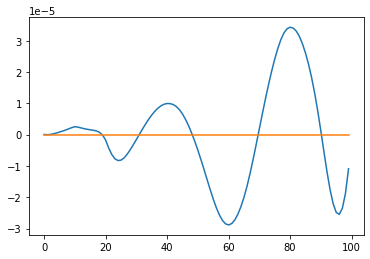

In [70]:
plt.plot([s.grad[-1].item() for s in stims])
plt.plot([0.0 for s in stims])

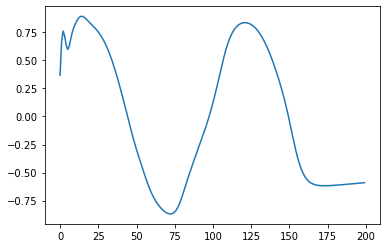

In [57]:
plt.plot([s[-1].item() for s in stims])

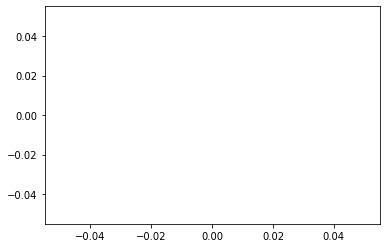

In [67]:
plt.plot(cpn_losses)

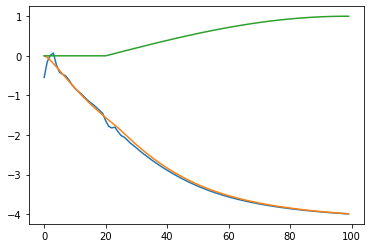

In [11]:
plt.plot(pred[0,:].detach().numpy())
plt.plot(all_obs[0,:].detach().numpy())
plt.plot(target[0,:,0].detach().numpy())
plt.show()


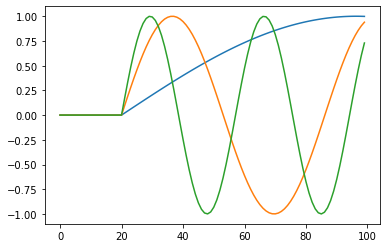

In [22]:
plt.plot(target[1,:,0].detach().numpy())
plt.plot(target[128,:,0].detach().numpy())

plt.plot(target[-1,:,0].detach().numpy())


nan
nan
2.5291595458984375


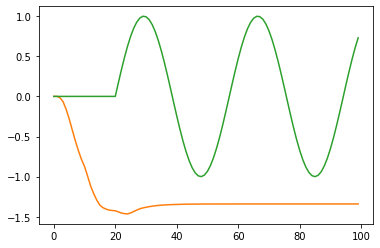

In [13]:
# Check fit of current ben and cpn
ben = recent_ben
cpn.reset()
ben.reset()

stims = []
pred = torch.zeros(batch_size, steps)
all_obs = torch.zeros(batch_size, steps)
noised = make_noised_cpn(cpn)
s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
thing = [Thing(init=x.item()) for x in target[:, 0, 0].detach().numpy()]

#cpn_temp = CPNNoiseyPassthrough(cpn)
for tidx in range(steps):
    obs = [t.observe() for t in thing]
    new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
    all_obs[:, tidx:tidx+1] = new_obs
          
    ind = target[:, tidx, 1:3].reshape(256,2)
    cpn_in = torch.cat((new_obs, ind), axis=1)
    new_stim = cpn(cpn_in)

    ben_in = torch.cat((new_obs, new_stim, ind), axis=1)
    cur_pred = ben(ben_in)
    pred[:, tidx] = cur_pred.squeeze()
        
    s.add(new_stim)
    n = s.get_next().detach().numpy()

    obs = []
    for bidx in range(batch_size):
        thing[bidx].step(n[bidx, 0].item())


loss = torch.nn.MSELoss()
print(loss(pred, target[:, :, 0]).item())
print(loss(pred, all_obs).item())
print(loss(all_obs, target[:, :, 0]).item())

plt.plot(pred[-1, :].detach().numpy())
plt.plot(all_obs[-1, :].detach().numpy())
plt.plot(target[-1, :, 0].detach().numpy())

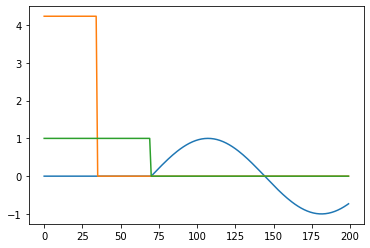

In [4]:
plt.plot(target[-1, :, 0].detach().numpy())
plt.plot(target[-1, :, 1].detach().numpy())
plt.plot(target[-1, :, 2].detach().numpy())